# Homework Assignment 2 - Exploring Supervised Learning: Multi-Class, Large-Margin, Non-linear and Non-parametric
### **Due:** Thursday, May 5, 11:59pm
### Total: 100 points

## Import all the libraries and tools you need below.

In [1]:
import os

os.getcwd()
os.chdir("C:\Data")
os.getcwd()

import pandas as pd
import numpy as np 
from numpy import log,dot,e,shape
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
onehot_encoder = OneHotEncoder(sparse=False)

from numpy import log,dot,e,shape
from numpy.linalg import norm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_blobs, make_circles

def pr_auc(y_true, probas_pred):
 # calculate precision-recall curve
 p, r, _ = precision_recall_curve(y_true, probas_pred)
 # calculate area under curve
 return auc(r, p)


## **1)** Multi-Class Logistic Regression (30 points)

In this question, you will extend your custom Logistic Regression model so that it can handle multiclass classification tasks. You will use the One-vs-All approach for this.

**a)** Upload the **phone_price.csv** file. Each instance in this dataset is a phone and the features are certain specifications. The **price_range** column is the price level of the phone, 0 being the cheapest and 3 being the most expensive. 

Split the features and the target column into different variables. Print how many instances there are for each class.

**(2 points)**

In [2]:
data = pd.read_csv('phone_price.csv')
X = data.drop(columns = 'price_range')
y = data['price_range']

In [3]:
X.sum()

battery_power    2477037.0
blue                 990.0
clock_speed         3044.5
dual_sim            1019.0
fc                  8619.0
four_g              1043.0
int_memory         64093.0
m_dep               1003.5
mobile_wt         280498.0
n_cores             9041.0
pc                 19833.0
px_height        1290216.0
px_width         2503031.0
ram              4248426.0
sc_h               24613.0
sc_w               11534.0
talk_time          22022.0
three_g             1523.0
touch_screen        1006.0
wifi                1014.0
dtype: float64

In [4]:
X.count()

battery_power    2000
blue             2000
clock_speed      2000
dual_sim         2000
fc               2000
four_g           2000
int_memory       2000
m_dep            2000
mobile_wt        2000
n_cores          2000
pc               2000
px_height        2000
px_width         2000
ram              2000
sc_h             2000
sc_w             2000
talk_time        2000
three_g          2000
touch_screen     2000
wifi             2000
dtype: int64

**b)** Split the data into training and test datasets with a **80-20** split. **Make sure you stratify with the target column.** Use **random_state=2**. Then, scale the features of both datasets.

**(2 points)**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 2, stratify=data[['price_range']])

**c)** Why is stratification important for this question even though the classes are balanced? **(2 points)**

Because price range is not binary, like 0 and 1's but rather from a range of 0-3.

**d)** Copy your custom Logistic Regression code from the previous assignment. **(0 points)**

In [12]:
def initialize(dimension):
    
    weights = np.random.rand(dimension,)
    bias = np.random.rand()
    return weights,bias

def predict(model_parameters,x_test, threshold):
    weights = model_parameters['weights']
    bias = model_parameters['bias']
    z = np.dot(X_test, weights) + bias
    y_pred = sigmoid(z)
    return (y_pred >= threshold).astype(int)

def sigmoid(z):
    y_output = 1/(1 + np.exp(-z))
    #y_output = np.maximum(y_output, 0.9999) #upper bound
    #y_output = np.minimum(y_output, 0.0001) #lower bound
    return y_output

def calculate_cost_gradient(weights,bias,x_train,y_train):
    
    z = np.dot(x_train,weights)
    
    # Calculate the cost
    y_output = sigmoid(np.dot(x_train,weights) + bias)
    cost = (-1/len(y_train)) * np.sum(np.dot(y_train, np.log(sigmoid(z)))
            + np.dot((1-y_train),np.log(1-sigmoid(z))))
    cost = np.sum(cost) / x_train.shape[0]
    
    # Gradients
    derivative_weight = np.dot(x_train.T,(y_output-y_train))/x_train.shape[0]
    derivative_bias = np.sum(y_output-y_train)/x_train.shape[0]
    gradients = {"Gradient Weight" : derivative_weight, "Gradient Bias" : derivative_bias}
    
    return cost,gradients

def GradientDescent(weights,bias,x_train,y_train,lr,iters,tol):
    costList = []
    index = []
    cost_previous = 999999999999
    
    #for each iteration, update weight and bias values
    for i in range(iters):
        old_weights = weights
        
        #For the current weights and bias, calculate the cost and the gradients
        cost,gradients = calculate_cost_gradient(weights,bias,x_train,y_train)
        #Update the weights and the bias
        weights = weights - lr * gradients["Gradient Weight"]
        bias = bias - lr * gradients["Gradient Bias"]
        
        new_weights = weights
        
        #Add the current cost and the intex to the list
        costList.append(cost)
        index.append(i)
        dif = cost_previous - cost
        if np.sqrt(np.sum((old_weights - new_weights)**2)) < tol:
            break
    
    if i == iters-1:
        print('Warning: Algorithm not converged.')
            
    #Save the trained weights and bias to the parameters dict
    model_parameters = {"weights": weights,"bias": bias}
    
    #Print the number of iterations and the cost
    print("iteration:",len(index))
    print("cost:",cost)

    #Plot to see how the cost decreased
    plt.plot(index,costList)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()
    
    #Return the final parameters
    return model_parameters

def logistic_regression(x_train,y_train,x_test,y_test,lr,iters, tol, threshold=0.5):

    weights,bias = initialize(x_train.shape[1])
    
    parameters = GradientDescent(weights,bias,x_train,y_train,lr,iters, tol)

    y_prediction = predict(parameters,x_test, threshold)
    
    print("Test Accuracy: {:.2f}%".format((100 - np.mean(np.abs(y_prediction - y_test))*100)))

**e)** Write a **logistic_regression_mc** function. It should take the exact same inputs as the custom logistic regression function above and return the parameters of all the models created as an array/dataframe. Call the function with the multi-class data. **(21 points)**

- Loop through all the possible class values. **Do not hard code, use the inputs.** Be careful about the order.
    - For each class value, create new train and test target columns.
    - Call logistic_regression with the new target values and return the optimum parameters.
    - Store the optimum parameters.
    - Calculate the class probabilities for the test data using optimum parameters and store them in an array/dataframe.
- Use argmax to return the class predictions.
- Print the accuracy, multi-class confusion matrix and precision/recall values for each class. You can use sklearn functions for this step. (For an easy way to get precision and recall, check **classification_report**.)

In [13]:
def logistic_regression_mc(x_train, y_train, x_test, 
                           y_test, lr, iters, tol, threshold = 0.5):
    
    dimension = y_train.nunique()
    dimension_ytrain = []
    dimension_ytest = []
    dimension_yprediction = []
    dimension_optimal_parameter = []
    dimension_weights = []
    dimension_bias = []

    for i in range(dimension):
        dimension_ytrain.append([])
        dimension_ytest.append([])
        dimension_yprediction.append([])
        dimension_optimal_parameter.append([])
        dimension_weights.append([])
        dimension_bias.append([])
    
    for i in range(dimension):
        dimension_ytrain[i] = (y_train[0:] == i).astype(int)
        dimension_ytest[i] = (y_test[0:] == i).astype(int)
        
        dimension_weights[i],dimension_bias[i] = initialize(x_train.shape[1])
    
        dimension_optimal_parameter[i] = GradientDescent(dimension_weights[i],
                                                         dimension_bias[i],
                                                         x_train,
                                     dimension_ytrain[i],lr,iters,tol)
        
        
        dimension_yprediction[i] = predict(dimension_optimal_parameter[i],x_test, threshold)
        
        print("Test Accuracy: {:.2f}%".format((100 - np.mean(
            np.abs(dimension_yprediction[i] - dimension_ytest[i]))*100)))
        
        print(np.argmax(dimension_yprediction[i]))
        
        #Multilabel confusion
    #print(multilabel_confusion_matrix(dimension_ytrain[i],
    #                                  dimension_yprediction[i],
    #                                 sample_weight=dimension_weights))
        #Precision Recall Curve
    #print(classification_report(dimension_ytrain[i],
    #                            dimension_yprediction[i],
    #                           sample_weight=dimension_weights))

C:\Users\dylan\AppData\Local\Temp/ipykernel_11876/3246653893.py:27: RuntimeWarning: divide by zero encountered in log
  + np.dot((1-y_train),np.log(1-sigmoid(z))))
C:\Users\dylan\AppData\Local\Temp/ipykernel_11876/3246653893.py:15: RuntimeWarning: overflow encountered in exp
  y_output = 1/(1 + np.exp(-z))
C:\Users\dylan\AppData\Local\Temp/ipykernel_11876/3246653893.py:26: RuntimeWarning: divide by zero encountered in log
  cost = (-1/len(y_train)) * np.sum(np.dot(y_train, np.log(sigmoid(z)))


iteration: 100
cost: nan


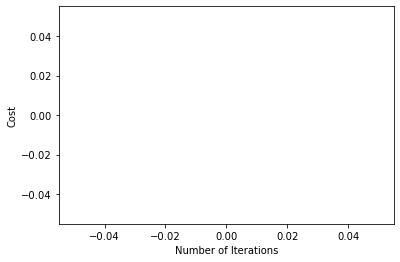

Test Accuracy: 82.50%
12
iteration: 100
cost: nan


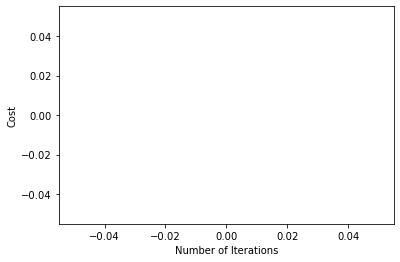

Test Accuracy: 62.00%
0
iteration: 100
cost: nan


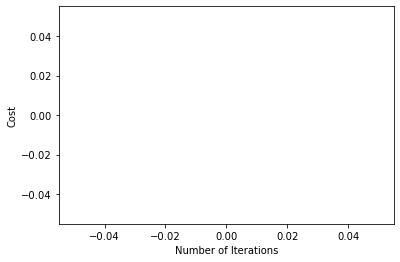

Test Accuracy: 75.00%
0
iteration: 100
cost: nan


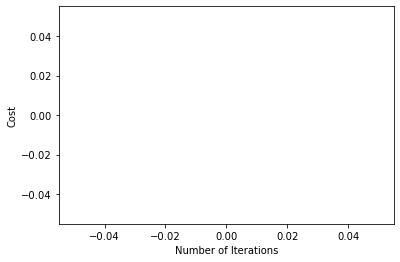

Test Accuracy: 74.50%
7


In [14]:
logistic_regression_mc(X_train, y_train, X_test, y_test,
                      lr = 1, iters = 100, tol = 0.01)

**f)** Which classes are easier to predict? Which classes have more misclassifications? What does this tell you about the price ranges? (The last question is open-ended.) **(3 points)**

class 0 and class 3 are the easiest predictions, which means that the values that fall in between 0 and 3 have a harder time being classified correctly as 1 or 2. This seems to mean that 1 and 2 classes are relatively similar to each other.

## **2)** Linear Support Vector Machine (SVM) Classifier Margin (30 points)

In this question, you will explore the linear SVM classifier from sklearn some more.

**a)** Use the **creditcard.csv** as you did in your **Apr18** in-class assignment. The task is to classify normal vs. fraudulent transactions and you need to 5-fold cross-validate a SVC model to find the best C and the best CV score. This far, you have already coded in your in-class assignment. For this assignment, you need to *find* some more information about the model for each C value:

- The number of support vectors for each C value. Note that the sklearn implementation calls any instance that is either on the margin or violates the margin a support vector.
- The percentage of misclassified instances among those that violate the margin. (Think about this one.)

**Note:**
- In order to add all this, you need to directly train a model, which has not been the case because the cross_val_score did that for you. You should keep cross_val_score to keep the CV results, but train one model on the entire training data separately as well to return the above information.
- Checking the SVC documentation will help with how to return the number of support vectors.
- No need to use the test data yet, as the main goal is inference.

**(10 points)**

In [15]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
class0 = data[data['Class'] == 0]

class1 = data[data['Class'] == 1]

class0_small = class0.sample(n=1000, random_state=2)

data_small = pd.concat([class0_small, class1])

y = data_small['Class']
X = data_small.drop(['Time', 'Amount', 'Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    random_state=0, 
                                                    test_size=0.3)

1.0032362459546926
1.0
0.9578947368421052
0.9130434782608695
0.8387096774193549
0.8032786885245902
0.8571428571428571
0.8727272727272727


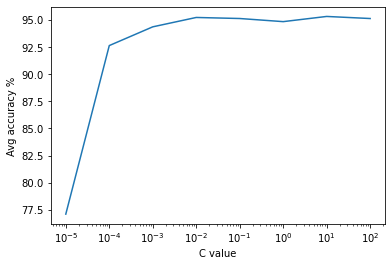

(array([ 14,  18,  22,  54,  58,  75,  99, 112, 206, 207, 219, 256, 293,
       312, 343, 439], dtype=int64),)
[array([309, 310]), array([184, 184]), array([95, 91]), array([69, 63]), array([62, 52]), array([61, 49]), array([56, 48]), array([55, 48])]


In [17]:
possible_hyperparam_vals = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

cv_scores = []
support_vectors = []

for val in possible_hyperparam_vals:
    svm = SVC(C=val, kernel='linear',random_state = 1)
    
    scores = cross_val_score(svm, X_train, y_train, cv=5)
    svm.fit(X_train, y_train)

    cv_scores.append(np.mean(scores)*100)
    support_vectors.append(svm.n_support_)
    print(svm.n_support_[1]/svm.n_support_[0])
    
plt.plot(possible_hyperparam_vals, np.array(cv_scores))
plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Avg accuracy %')
plt.show()

y_test = np.asarray(y_test)
misclassified = np.where(y_test != svm.predict(X_test))
print(misclassified)
print(support_vectors)

In [18]:
len(misclassified[0])/len(svm.predict(X_test))*100
#Around 3.57% is misclassified

3.571428571428571

**b)** What do the results tell you about the distribution of the credit card transaction data and the limitations of a linear decision boundary? Keep in mind that:
- As the margin gets tighter/larger, the decision boundary also changes.
- There are support vectors that can be outside the margin but on the wrong side of it.

**(5 points)**

- SVM seems not suitable for large datasets as the linearity of the algorithm is undermined by the fact that the data set has more noise. If one wants to find a pattern outside a pattern that can easily be divided into by a linear pattern, then linear SVM seems not to be suitable for because support vectors can lie outside the margin but on the wrong side as the linearity can become strict as the margin becomes tighter.

**c)** Using the best C value (picked with CV) and another 5-fold cross-validation, find the decision threshold that returns at least 95% recall and a precision as high as possible.
- Note that **cross_val_predict** returns the class prediction probabilities for each instance when that instance was in the validation fold. It needs **method="predict_proba"**.
- You need to try all possible threshold values with a stepsize 0.01.
- Unlike, cross_val_score, cross_val_predict is used before a for loop, not in it.
- Initializing an empty dataframe and storing information there as the loop goes is highly suggested in order to easily return the threshold value you are looking for. 

**(15 points)**

In [26]:
# evaluate a model
def evaluate_model(X, y, model):
     # define evaluation procedure
    cv = StratifiedKFold(n_splits=10)
     # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
     # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [27]:
svm = SVC(C=possible_hyperparam_vals[np.argmax(cv_scores)], 
          kernel='linear',random_state = 1, probability=True)

#Train the classifier
svm.fit(X_train, y_train)

#Predict the test labels
y_pred = svm.predict(X_test)

# Evaluate the classifier
acc = svm.score(X_test, y_test)*100

print(acc)
print(confusion_matrix(y_pred, y_test))
print(precision_score(y_pred, y_test))
print(recall_score(y_pred, y_test))

95.75892857142857
[[299  17]
 [  2 130]]
0.8843537414965986
0.9848484848484849


In [28]:
c_score_cv = cross_val_predict(svm, X_train, y_train, 
                               method = "predict_proba")
c_score_cv[possible_hyperparam_vals[np.argmax(cv_scores)]]

array([0.94744253, 0.05255747])

In [29]:
#desicion threshold seems to be 0.05255747

In [31]:
# evaluate the model
scores = evaluate_model(X_train, y_train, svm)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean PR AUC: nan (nan)


## 3) Non-linear SVM (20 points)

**a)** Upload the **magic_telescope.csv** file, which contains simulated measurements taken from [MAGIC telescope](https://en.wikipedia.org/wiki/MAGIC_(telescope)), used to detect gamma rays. Each instance in this dataset is a detection of an electromagnetic shower and the features are certain physical measurements. The last column shows whether the shower is caused by a gamma ray (g) or cosmic rays in the upper atmosphere - called a hadronic shower. (h)

- While uploading the file, use **header=None** because the feature names are not given in the first row of the csv file.
- Split the target (last) column and the features (everything else) into different variables. 
- Convert the target vector into 0s and 1s. 
- Split the data into training and test datasets with a **70-30 split**. Make sure you **stratify** with the target column. Use **random_state=2**. 
- Scale the features of both datasets.

**(3 points)**

In [32]:
data = pd.read_csv('magic_telescope.csv', header = None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [33]:
y = data[10]
X = data.drop(columns = [10])
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            random_state=2, test_size=0.3,
                                            stratify=data[[10]])

In [34]:
sc = StandardScaler()

sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
#y_train_scaled = sc.transform(y_train)
#y_test_scaled = sc.transform(y_test)

**b)** The best linear SVM classifier returns around 79% accuracy for this dataset. (Feel free to check it out!) In this question, you will find out how much a kernelized SVM improves this.

Find the best (or close enough) kernel and its best (or close enough) hyperparameter value by a grid search. Note that C, the regularization hyperparameter, is still there.
- For C, use the values from 0.01 to 10, with an order of magnitude stepsize.
- For the degree of the polynomial kernel, use 2, 3, 4.
- For the gamma of the RBF kernel, use the values from 0.001 to 1, with an order of magnitude stepsize.

**Note:**
- Do not forget to put the kernel type in the grid.
- The hyperparameter grid would still work with everything above put together, even though RBF kernel does not take a degree, or the polynomial kernel a gamma.
- One thing to be careful while cross-validating data with unbalanced classes is to stratify the class values to each fold. This cannot be implemented by simply inputting cv=5 to the grid search object. So, you need an object that further customizes your split into folds. Check **StratifiedKFold** object.
- A kernelized SVM is already slow to train. With such a big grid, it will take ages to run. Feel free to use GridSearchCV if you have confidence in your machine and/or have GPU access (and want **10 bonus points**), but using **RandomizedSearchCV** is highly suggested. Use **random_state=15**. Pick the number of sampled hyperparameter combos (**n_iter**) as you wish, as long as the best estimator exceeds 85% CV accuracy. Finally, return the test accuracy for the final model.
- Setting **verbose=2** will show you where the grid search is as the code runs.

**(17 points)**

In [43]:
C = [0.01, 0.1, 1, 10]

param_grid = {'weights': ['uniform', 'distance'], 
              'C':[0.01, 0.1, 1, 10]}

svm = SVC(C=C[0], kernel='poly',degree=3,random_state = 1, 
          probability=True, verbose = 2)

svm.fit(X_train_scaled, y_train)

randomCV = RandomizedSearchCV(svm, param_grid, 
                              random_state=15, n_iter=25)

[LibSVM]

In [46]:
randomCV.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_iter', 'n_jobs', 'param_distributions', 'pre_dispatch', 'random_state', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [49]:
search = randomCV.fit(X_train_scaled, y_train)
search.cv_results_['estimator__kernel']

C:\Users\dylan\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=25. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ValueError: Invalid parameter weights for estimator SVC(C=0.01, kernel='poly', probability=True, random_state=1, verbose=2). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
svm = SVC(C=C[2], kernel='poly',random_state = 1, probability=True)
svm.fit(X_train_scaled, y_train)

#Train the classifier
svm.fit(X_train_scaled, y_train)

param_grid = {'weights': ['uniform', 'distance'], 'n_neighbors':range(1, 50, 2)}

#GBC = GradientBoostingClassifier()
#parameters = {'learning_rate': [0.01,0.02,0.03],
#                  'subsample'    : [0.9, 0.5, 0.2],
#                  'n_estimators' : [100,500,1000],
#                  'max_depth'    : [4,6,8]
#                 }

grid_GBC = GridSearchCV(estimator=svm, param_grid = param_grid, 
                        cv = 2, n_jobs=500)
grid_GBC.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Evaluate the classifier
acc = svm.score(X_test, y_test)*100

print(acc)
print(confusion_matrix(y_pred, y_test))
print(precision_score(y_pred, y_test))
print(recall_score(y_pred, y_test))

## 4) KNN with Custom Weights (15 points)

In this question, you will expand the grid of n_neighbors and weights you coded in your **Apr20** in-class assignment.

The weights input only has two built-in options: **'uniform'**, which means all neighbors have the same weight on the prediction and **'distance'**, which means the weights of the neighbors are inversely proportional with their distance to the predicted instance.

While some other languages, such as R, give you some more built-in options on the weights, Python/sklearn gives you the option to define the weights method yourself as a user-defined function. You can then use the name of your function as the weights input. You need to write two user-defined functions and add them to the grid.

- Note that all functions must have one input and one output only. The input is an array, which has the distances, and the output is an array of the same length as the input, which has the weights.
- Write a **dist_sq** function, which returns $weights = \frac{1}{(distances)^2}$.
- Write a **dist_g10** function, which returns $weights = \frac{1}{10*\sqrt(2\pi)} * e^{-distances^2/(2*10^2)}$. Note that this is the Gaussian equation with zero mean and sigma = 10.

Add the functions to the weights part of your grid and rerun the whole thing with the same dataset. Return the best hyperparameter set and the test RMSE of the model with those hyperparameters. Note that you need to use the function names directly, not as strings.

**Final Note from Emre:** For the life of me, I could not figure out how to use a user-defined function with multiple inputs (such as sigma as the second input instead of defining a function with a fixed sigma) as an input to a KNN object. Anyone who figures this out (if it is possible at all) will get **40 bonus points**.

In [51]:
knn = KNeighborsRegressor()

param_grid = {'weights': ['uniform', 'distance'],
              'dist_sq': [1/(np.square(np.pi))],
              'dist_g10': [1/(10*(np.sqrt(2*(np.pi))))],
              'n_neighbors':range(1, 50, 2)}

grid = GridSearchCV(knn, param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=False, verbose=1)
 
grid.fit(X_train_scaled, y_train)

print(grid.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


ValueError: Invalid parameter dist_g10 for estimator KNeighborsRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [52]:
knn = KNeighborsRegressor()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=False, verbose=1)
 
grid.fit(X_train_scaled, y_train)

print(grid.best_params_)
print(grid.best_score_)

results = grid.cv_results_

results_df = pd.DataFrame(results['params'])
results_df['MAE'] = -results['mean_test_score']
results_df2 = results_df.pivot(index='n_neighbors', columns='weights', values='MAE')
sns.heatmap(results_df2)
plt.plot()

knn_final = KNeighborsRegressor(n_neighbors=grid.best_params_['n_neighbors'], weights=grid.best_params_['weights'])
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


ValueError: Invalid parameter dist_g10 for estimator KNeighborsRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [53]:
knn_final = KNeighborsRegressor(n_neighbors=grid.best_params_['n_neighbors'], weights=grid.best_params_['weights'])
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print(np.sqrt(mean_squared_error(y_test, y_pred_rf)))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## 5) Final KNN Question (5 points)

While KNN is a powerful model and very easy to implement and understand, come up with two different reasons why it can create problems in real-life situations. (Think about how long the prediction stage takes and what is necessary to have for that prediction stage. You can also compare it to a parametric model.)

- The runtime of KNN can be very long, and thus take more resources than possible
- https://www.mygreatlearning.com/blog/knn-algorithm-introduction/ according to this website, KNN is a lazy algorithm meaning it doesn't use any of the training data to make generalizations, which could be problematic for the reason that one might aim to make generalizations for data simplification reasons amongst other reasons.